<a href="https://colab.research.google.com/github/tcdixon4/loog-fun/blob/master/2020_preseason_team_ranker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 Preseason Team Ranker

This notebook contains a data-driven preseason ranking system. It has two fundamental pieces:

1. Using historical data over the past 3 season, create a model that predicts the average weekly scoring of an individual based on their position and ESPN preseason PPR ranking. 

$\hspace{30pt} \bar{S}_{player} = f(position, rank)$

2. Plug the top position players for each team into the model (top QB, top 2 RB, top 2 WR, top TE, top flex) to estimate their weekly scoring. Rank based on these values.

## Plotting the historical data

First we will plot data from the past 3 seasons. 

Along the X-axis we have the preseason rankings from ESPN ([2017](https://www.espn.com/fantasy/football/story/_/page/17RanksPreseason200PPR/2017-fantasy-football-ppr-rankings-top-200), [2018](https://www.espn.com/fantasy/football/story/_/page/18RanksPreseason300PPR/2018-fantasy-football-ppr-rankings-top-300), [2019](https://www.espn.com/fantasy/football/story/_/id/25759239/fantasy-football-2019-updated-top-200-ppr-rankings-matthew-berry)). The top 100 players from each season were used.

Along the Y-axis is the corresponding weekly average score for each player at the end of the season gathered from fantasypros ([2017](https://www.fantasypros.com/nfl/reports/leaders/ppr.php?year=2017), [2018](https://www.fantasypros.com/nfl/reports/leaders/ppr.php?year=2018), [2019](https://www.fantasypros.com/nfl/reports/leaders/)). Note that the same player can be plotted as 3 independent datapoints (once in each season). No outliers were removed, but using the weekly average score as opposed to season total should mitigate the effect of injuries.

In [2]:
#@title
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Load in data
url = 'https://raw.githubusercontent.com/tcdixon4/loog-fun/master/data/' \
      'ff_preseason_rankings_eos_scoring.csv'
headers = ['first_name','last_name','position','pre_ranking','points_ttl',
           'games','points_avg']
df = pd.read_csv(url, names=headers)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


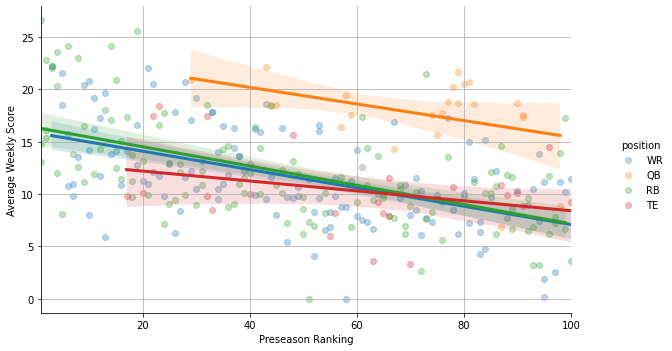

In [3]:
#@title
# Plot scatter and regression lines separately for each position, overlayed
score_plot = sns.lmplot(x='pre_ranking', y='points_avg', hue="position", 
                     data=df,fit_reg=True, scatter_kws = {'alpha': 0.3}, 
                     line_kws = {'linewidth': 3}) 
score_plot.ax.grid(b=True, which='major', axis='both')
score_plot.fig.set_size_inches(10, 5)
score_plot.set_axis_labels('Preseason Ranking', 'Average Weekly Score')
pass

Unsurprisingly, we see that players with higher preseason rankings tend to score more at each position. The point is that now we can formalize just how much difference having a preseason rank of 1 vs 20 makes on the expected in-season performance. We can also model these relationships to predict future scoring using the preseason rankings for the current season.

## Modelling future player performance and predicting team rankings

Using the linear regression models represented by the fit lines in the first figure, we can predict the performance of all players for the current season. Below is a stacked bar chart representing the positional breakdown of expected scoring for each of the starting lineups heading into the first week in the League of Ordinary Gentlemen. In this way, we can obtain a sort of preseason ranking for each of the fantasy teams.

In [4]:
#@title
# Fit models for each position
x_QB = df[df['position'].str.match('QB')]['pre_ranking'].values.reshape(-1,1)
y_QB = df[df['position'].str.match('QB')]['points_avg'].values.reshape(-1,1)
QB_mdl = LinearRegression()  
QB_mdl.fit(x_QB, y_QB)

x_RB = df[df['position'].str.match('RB')]['pre_ranking'].values.reshape(-1,1)
y_RB = df[df['position'].str.match('RB')]['points_avg'].values.reshape(-1,1)
RB_mdl = LinearRegression()  
RB_mdl.fit(x_RB, y_RB)

x_WR = df[df['position'].str.match('WR')]['pre_ranking'].values.reshape(-1,1)
y_WR = df[df['position'].str.match('WR')]['points_avg'].values.reshape(-1,1)
WR_mdl = LinearRegression()  
WR_mdl.fit(x_WR, y_WR)

x_TE = df[df['position'].str.match('TE')]['pre_ranking'].values.reshape(-1,1)
y_TE = df[df['position'].str.match('TE')]['points_avg'].values.reshape(-1,1)
TE_mdl = LinearRegression()  
TE_mdl.fit(x_TE, y_TE)
pass

In [5]:
#@title
# Load in data
url = 'https://raw.githubusercontent.com/tcdixon4/loog-fun/master/data/' \
      'loog_team_composition.csv'
headers = ['team','QB','RB1','RB2','WR1','WR2','TE','RB3','WR3']
teams_df = pd.read_csv(url, names=headers)

In [6]:
#@title
# Predict the scoring at each position for each team
QB_scores = QB_mdl.predict(teams_df['QB'].values.reshape(-1,1))
RB1_scores = RB_mdl.predict(teams_df['RB1'].values.reshape(-1,1))
RB2_scores = RB_mdl.predict(teams_df['RB2'].values.reshape(-1,1))
WR1_scores = WR_mdl.predict(teams_df['WR1'].values.reshape(-1,1))
WR2_scores = WR_mdl.predict(teams_df['WR2'].values.reshape(-1,1))
TE_scores = TE_mdl.predict(teams_df['TE'].values.reshape(-1,1))
FLEX_scores = np.zeros([10,1])
for idx, team in teams_df.iterrows():
  if np.isnan(team['RB3']):
    FLEX_scores[idx] = WR_mdl.predict(np.array([[team['WR3']]]))
  else:
    FLEX_scores[idx] = RB_mdl.predict(np.array([[team['RB3']]]))

# Log the predicting scoring in the dataframe
teams_df['QB_scores'] = QB_scores
teams_df['RB1_scores'] = RB1_scores
teams_df['RB2_scores'] = RB2_scores
teams_df['WR1_scores'] = WR1_scores
teams_df['WR2_scores'] = WR2_scores
teams_df['TE_scores'] = TE_scores
teams_df['FLEX_scores'] = FLEX_scores
teams_df['total_scores'] = QB_scores \
                           + RB1_scores \
                           + RB2_scores \
                           + WR1_scores \
                           + WR2_scores \
                           + TE_scores \
                           + FLEX_scores
teams_df = teams_df.sort_values(by=['total_scores'], ascending=False)

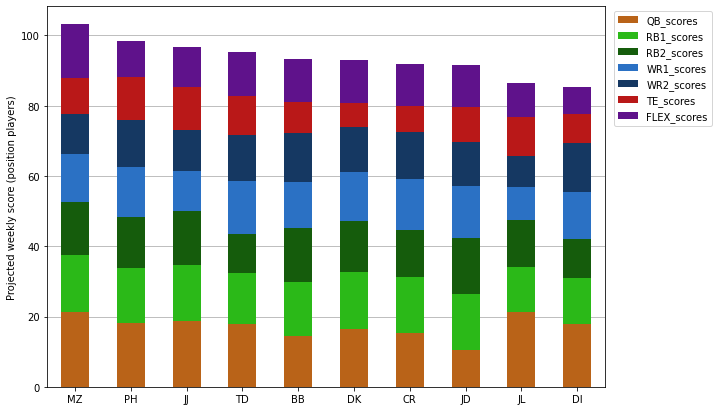

In [7]:
#@title
# Plot the positional scoring breakdowns for each team as a stacked bar chart
colors = ['#B96318','#2BB918','#155C0C','#2B71C4','#153862','#B91818','#5F128B']
score_pred_plot = teams_df.loc[:,['QB_scores','RB1_scores','RB2_scores',
                                  'WR1_scores','WR2_scores','TE_scores',
                                  'FLEX_scores',]].plot.bar(stacked=True, 
                                  figsize=(10,7), color=colors)
score_pred_plot.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
score_pred_plot.grid(b=True, which='major', axis='y')
score_pred_plot.set_axisbelow(True)
score_pred_plot.set_xticklabels(teams_df['team'], rotation=0)
score_pred_plot.set_ylabel('Projected weekly score (position players)')
pass

And there we have it - models to formalize the relationship between preseason rankings and in-season scoring, as well as preseason league rankings expressed as expected weekly scoring using those models. Of course, some experts have likely created their own expected scoring estimates so that we wouldn't have to regress scoring on rankings, but then we would miss out on all the machine learning fun!

Good luck with the season!